# Converting Pre-trained Models from Tensorflow to ONNX

[**MODEL ZOO**](https://modelzoo.co/)

Tensorflow has a large selection of pre-trained ssd models in its [object detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

ONNX has its [own model zoo](https://github.com/winnerineast/models-onnx)

This tutorial shows how to convert them to ONNX and run them under [onnxruntime](https://github.com/microsoft/onnxruntime).


We use [ssd_mobilenet_v1_coco](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz) as example in this tutorial. Other models should work as well.

ONNX has support for various ops needed for SSD models since opset-10 so you'll need to use onnx-1.5 or better and a runtime that supports opset-10.

In [1]:
%pip install --upgrade ipymagic -q
#import ipymagic
%load_ext ipymagic

%python --version

Note: you may need to restart the kernel to use updated packages.
Python 3.7.7


In [2]:
import os
import sys
import time
from glob import glob

import numpy as np
import tensorflow as tf
import onnx
import tf2onnx
import onnxmltools
import onnxruntime

## Base Environment
Before we start, lets setup some variables where to find things.

In [3]:
print(f"""
For this tutorial use used the following versions:

python      : {sys.version.split(' ')[0]}
numpy       : {np.__version__}
tensorflow  : {tf.__version__}
onnx        : {onnx.__version__}
tf2onnx     : {tf2onnx.__version__}
onnxmltools : {onnxmltools.__version__}
onnxruntime : {onnxruntime.__version__}
""")


For this tutorial use used the following versions:

python      : 3.7.7
numpy       : 1.16.0
tensorflow  : 1.15.2
onnx        : 1.6.0
tf2onnx     : 1.5.6
onnxmltools : 1.6.1
onnxruntime : 1.1.1



In [4]:
# For onnx build
!cmake --version

cmake version 3.14.0

CMake suite maintained and supported by Kitware (kitware.com/cmake).


In [5]:
os.environ

environ{'PATH': '/opt/conda/envs/onnx-tf1-15/bin:/opt/conda/bin:/opt/conda/bin:/opt/conda/sbin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'HOSTNAME': '953a4ce29285',
        'TERM': 'xterm-color',
        'CONDA_PATH': '/opt/conda',
        'JUPYTER_CONFIG_DIR': '/opt/conda/etc/jupyter',
        'JUPYTER_DATA_DIR': '/opt/conda/share/jupyter',
        'JAVA_HOME': '/usr/lib/jvm/default-java',
        'WORKDIR': '/workspace',
        'HOME': '/root',
        'LC_CTYPE': 'C.UTF-8',
        'KERNEL_LAUNCH_TIMEOUT': '40',
        'PYTHONPATH': '/opt/conda/envs/onnx-tf1-15/bin/python',
        'JPY_PARENT_PID': '1',
        'CLICOLOR': '1',
        'PAGER': 'cat',
        'GIT_PAGER': 'cat',
        'MPLBACKEND': 'module://ipykernel.pylab.backend_inline'}

In [6]:
ROOT = os.environ['WORKDIR']  # '/workspace'
WORK = os.path.join(ROOT, "trained_models")
os.environ['WORK'] = WORK

os.makedirs(WORK, exist_ok=True)

# Enforce `tf2onnx` to CPU
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

---
# Benchmark: `tf`, `tf2onnx`

In [7]:
MODEL = "resnet50"

os.environ['MODEL'] = MODEL
MODEL_PATH = os.path.join(WORK, MODEL)
os.environ['MODEL_PATH'] = MODEL_PATH
os.environ['MODEL_PATH_TF'] = MODEL_PATH_TF = os.path.join(MODEL_PATH, 'tf', MODEL)
os.environ['MODEL_PATH_H5'] = MODEL_PATH_H5 = os.path.join(MODEL_PATH, 'h5', MODEL)

In [14]:
os.environ['TF_KERAS'] = '1'
import keras2onnx


print(f'keras2onnx: {keras2onnx.__version__}')

resnet50v2 = tf.keras.applications.ResNet50V2()

for _typ in ['tf', 'h5']:
    dirname = os.path.join(MODEL_PATH, _typ)
    os.makedirs(dirname, exist_ok=True)
    filename = os.path.join(dirname, MODEL)
    resnet50v2.save(
        filepath=filename if _typ == 'tf' else f'{filename}.h5',
        overwrite=True,
        include_optimizer=True,
        save_format=_typ,  # {'tf', 'h5'}
        signatures=None,
    )

onnx_model = keras2onnx.convert_keras(resnet50v2)

os.makedirs(f'{MODEL_PATH_TF}/onnx_model/', exist_ok=True)
onnx.save_model(onnx_model, f'{MODEL_PATH_TF}/onnx_model/from_frozen_with_keras2onnx.onnx')

keras2onnx: 1.6.1
INFO:tensorflow:Assets written to: /workspace/trained_models/resnet50/tf/resnet50/assets


In [17]:
!tree $MODEL_PATH

/workspace/trained_models/resnet50
├── h5
│   └── resnet50.h5
└── tf
    └── resnet50
        ├── assets
        ├── onnx_model
        │   └── from_frozen_with_keras2onnx.onnx
        ├── saved_model.pb
        └── variables
            ├── variables.data-00000-of-00002
            ├── variables.data-00001-of-00002
            └── variables.index

6 directories, 6 files


In [18]:
!curl -fsSL http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz | tar zxf -

In [19]:
data_paths = glob("101_ObjectCategories/*[!BACKGROUND_Google]/*.jpg")
print(len(data_paths))
data_paths[:5]

7285


['101_ObjectCategories/revolver/image_0077.jpg',
 '101_ObjectCategories/revolver/image_0053.jpg',
 '101_ObjectCategories/revolver/image_0030.jpg',
 '101_ObjectCategories/revolver/image_0027.jpg',
 '101_ObjectCategories/revolver/image_0070.jpg']

## RUN `tf_model`

In [20]:
os.environ['TF_MODEL_PATH'] = TF_MODEL_PATH = os.path.join(
    os.environ['MODEL_PATH_TF'],
    'saved_model.pb',
)

In [21]:
tf_model = tf.keras.models.load_model(os.environ['MODEL_PATH_TF'])

In [22]:
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import math
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

In [23]:
raw_data_paths = glob("101_ObjectCategories/*[!BACKGROUND_Google]/*.jpg")
print(len(raw_data_paths))
raw_data_paths[:5]

7285


['101_ObjectCategories/revolver/image_0077.jpg',
 '101_ObjectCategories/revolver/image_0053.jpg',
 '101_ObjectCategories/revolver/image_0030.jpg',
 '101_ObjectCategories/revolver/image_0027.jpg',
 '101_ObjectCategories/revolver/image_0070.jpg']

In [24]:
def get_proper_image_path(img_path):
    x = Image.open(img_path)
    x = np.asarray(x)
    return img_path if x.ndim > 2 else None

In [25]:
data_paths = list(filter(None, (get_proper_image_path(p) for p in raw_data_paths)))
print(len(data_paths))

7077


In [26]:
def get_image(img_path):
    x = Image.open(img_path)
    x = np.asarray(x)
    # x = preprocess_input(x)
    return x

In [27]:
%pip install --upgrade unipy

     |████████████████████████████████| 9.5 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 206 kB 2.0 MB/s eta 0:00:01
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 26.5 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 215 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 540 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 987 kB 61.1 MB/s eta 0:00:01
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
     |████████████████████████████████| 56 kB 477 kB/s  eta 0:00:01
     |████████████████████████████████| 759 kB 65.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 45.7 MB/s eta 0:00:01
  Using cached google_auth-1.14.1-py2.py3-none-any.whl

In [34]:
from unipy.utils.generator import ReusableGenerator, re_generator

In [28]:
def get_prep_image(img_path, target_size=None):
    x = tf.keras.preprocessing.image.load_img(
        img_path,
        grayscale=False,
        color_mode='rgb',  # Image
        target_size=target_size,
        interpolation='nearest',
    )
    x = np.asarray(x)
    x = preprocess_input(x)  # mode: One of "caffe", "tf", "torch"
    x = np.expand_dims(x, axis=0)
    return x

# mode: One of "caffe", "tf" or "torch".
#     - caffe: will convert the images from RGB to BGR,
#         then will zero-center each color channel with
#         respect to the ImageNet dataset,
#         without scaling.
#     - tf: will scale pixels between -1 and 1,
#         sample-wise.
#     - torch: will scale pixels between 0 and 1 and then
#         will normalize each channel with respect to the
#         ImageNet dataset.

In [29]:
data_array_gen = (get_image(f) for f in data_paths)
data_prep_gen = (get_prep_image(f) for f in data_paths)

In [30]:
#%%timeit
import time


t = time.perf_counter()

pred = tf_model.predict(
    data_prep_gen,
    steps=len(data_paths),
    workers=1,
    max_queue_size=128,  # Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. 
    use_multiprocessing=False,  # Used for generator or keras.utils.Sequence input only.
    verbose=1,
)
print(time.perf_counter() - t)

7077/7077 [==============================] - 408s 58ms/step
408.36599537099937


```sh
CONTAINER ID        NAME                CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
bdf1a647146f        admiring_wu         579.78%             28.77GiB / 62.85GiB   45.77%              2.2GB / 717MB       840MB / 2.26GB      227
```

In [31]:
print(type(pred))
print(pred[0].shape)

pred_decoded_tf = decode_predictions(pred)
pred_decoded_tf[-3:]

<class 'numpy.ndarray'>
(1000,)
40960/35363 [==================================] - 0s 1us/step


[[('n02437616', 'llama', 0.15925159),
  ('n02417914', 'ibex', 0.10049338),
  ('n02391049', 'zebra', 0.07378857),
  ('n02423022', 'gazelle', 0.041579306),
  ('n02125311', 'cougar', 0.02804535)],
 [('n02389026', 'sorrel', 0.17463423),
  ('n02391049', 'zebra', 0.06998125),
  ('n02437312', 'Arabian_camel', 0.056545377),
  ('n02417914', 'ibex', 0.051300034),
  ('n02422106', 'hartebeest', 0.03356029)],
 [('n02391049', 'zebra', 0.63725334),
  ('n02389026', 'sorrel', 0.15998408),
  ('n02423022', 'gazelle', 0.0069316197),
  ('n03967562', 'plow', 0.0067086597),
  ('n03538406', 'horse_cart', 0.004334446)]]

## RUN `onnx_model`

In [32]:
import onnx.onnx_cpp2py_export.optimizer as C

os.environ['ONNX_MODEL_PATH'] = ONNX_MODEL_PATH = os.path.join(
    MODEL_PATH_TF,
    'onnx_model',
    'from_frozen_with_keras2onnx.onnx',
)

# onnx_model = onnx.load(ONNX_MODEL_PATH)
# onnx_model_str = onnx_model.SerializeToString()
# optimized_model_str = C.optimize(onnx_model_str, passes=None)
# onnx_model_optimized = onnx.load_from_string(optimized_model_str)
# onnx_model_optimized = onnx.optimizer.optimize(onnx_model)

In [35]:
#data_array_gen = (get_image(f) for f in data_paths)
data_prep_gen = ReusableGenerator(get_prep_image(f) for f in data_paths)

In [36]:
import onnx
import onnxruntime as rt
import onnx.onnx_cpp2py_export.optimizer as C


class ONNXInference(object):
    def __init__(self, model_path, optimize=False):
        self.model = onnx.load(model_path)
        if optimize:
            onnx_model_str = self.model.SerializeToString()
            optimized_model_str = C.optimize(onnx_model_str, passes=None)
            self.model = onnx.load_from_string(optimized_model_str)

        self._prepare_runtime(model_path)
    
    def _prepare_runtime(self, model_path):
        self.sess = rt.InferenceSession(os.path.join(model_path))
        self.onnx_inputs = [i.name for i in self.sess.get_inputs()]
        self.onnx_outputs = [o.name for o in self.sess.get_outputs()]
        
        print(f'inputs : {self.onnx_inputs}')
        print(f'outputs: {self.onnx_outputs}')
        #self.onnx_model = onnx.load(model_path)
        
    def predict(self, x):
        if len(x) == len(self.onnx_inputs):
            input_dict = {i: x_i for i, x_i in zip(self.onnx_inputs, x)}
            return self.sess.run(self.onnx_outputs, input_dict)
        else:
            raise Exception(f"The given input number '{len(x)}' and onnx model input number should be the same.")

In [37]:
onnx_infe_model = ONNXInference(ONNX_MODEL_PATH)

inputs : ['input_2']
outputs: ['probs']


* Error: `INVALID_ARGUMENT: Invalid rank for input`: expand a rank

In [38]:
data_prep_gen = ReusableGenerator(get_prep_image(f) for f in data_paths)

pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: input_2 Got: 3 Expected: 4 Please fix either the inputs or the model.

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
inputs : ['input_11']
outputs: ['probs']
(1, 224, 224, 3)
---------------------------------------------------------------------------
InvalidArgument                           Traceback (most recent call last)
<ipython-input-496-55e97e795691> in <module>
      1 data_prep_gen = ((get_prep_image(f) for f in data_paths))
----> 2 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-496-55e97e795691> in <listcomp>(.0)
      1 data_prep_gen = ((get_prep_image(f) for f in data_paths))
----> 2 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-494-8a5b0484dd1b> in predict(self, x)
     26         if len(x) == len(self.onnx_inputs):
     27             input_dict = {i: x_i for i, x_i in zip(self.onnx_inputs, x)}
---> 28             return self.sess.run(self.onnx_outputs, input_dict)
     29         else:
     30             raise Exception(f"The given input number '{len(x)}' and onnx model input number should be the same.")

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnxruntime/capi/session.py in run(self, output_names, input_feed, run_options)
    140             output_names = [output.name for output in self._outputs_meta]
    141         try:
--> 142             return self._sess.run(output_names, input_feed, run_options)
    143         except C.EPFail as err:
    144             if self._enable_fallback:

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: input_11 Got: 3 Expected: 4 Please fix either the inputs or the model.
```

</div>

: ONNX loaded model requires an expanded axis.  

* Error: `INVALID_ARGUMENT: Got invalid dimensions for Input`: ONNX need fixed size

In [39]:
data_prep_gen = ReusableGenerator(np.expand_dims(get_prep_image(f), axis=0) for f in data_paths)

pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input_2 for the following indices
 index: 1 Got: 197 Expected: 224
 index: 2 Got: 300 Expected: 224
 Please fix either the inputs or the model.

<div class="alert alert-block alert-danger">
<b>Error</b> <br>
    
```sh
inputs : ['input_11']
outputs: ['probs']
(1, 1, 197, 300, 3)
---------------------------------------------------------------------------
InvalidArgument                           Traceback (most recent call last)
<ipython-input-499-92ec9554f4cf> in <module>
      1 data_prep_gen = (np.expand_dims(get_prep_image(f), axis=0) for f in data_paths)
      2 
----> 3 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-499-92ec9554f4cf> in <listcomp>(.0)
      1 data_prep_gen = (np.expand_dims(get_prep_image(f), axis=0) for f in data_paths)
      2 
----> 3 pred = [onnx_infe_model.predict(img) for img in data_prep_gen]

<ipython-input-494-8a5b0484dd1b> in predict(self, x)
     26         if len(x) == len(self.onnx_inputs):
     27             input_dict = {i: x_i for i, x_i in zip(self.onnx_inputs, x)}
---> 28             return self.sess.run(self.onnx_outputs, input_dict)
     29         else:
     30             raise Exception(f"The given input number '{len(x)}' and onnx model input number should be the same.")

/opt/conda/envs/onnx-tf1-15/lib/python3.7/site-packages/onnxruntime/capi/session.py in run(self, output_names, input_feed, run_options)
    140             output_names = [output.name for output in self._outputs_meta]
    141         try:
--> 142             return self._sess.run(output_names, input_feed, run_options)
    143         except C.EPFail as err:
    144             if self._enable_fallback:

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input_11 for the following indices
 index: 1 Got: 197 Expected: 224
 index: 2 Got: 300 Expected: 224
 Please fix either the inputs or the model.
```

</div>

: ONNX loaded model requires a fixed size input.  

[ref1: Common errors with `onnxruntime`](http://www.xavierdupre.fr/app/onnxruntime/helpsphinx/auto_examples/plot_common_errors.html)

In [40]:
def get_prep_image(img_path, target_size=None):
    x = tf.keras.preprocessing.image.load_img(
        img_path,
        grayscale=False,
        color_mode='rgb',
        target_size=target_size,
        interpolation='nearest',
    )
    x = np.asarray(x)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    return x

In [41]:
data_prep_fixed_size_gen = ReusableGenerator(get_prep_image(f, target_size=(224, 224)) for f in data_paths)
data_prep_for_onnx_gen = ReusableGenerator(np.expand_dims(l, axis=0) for l in data_prep_fixed_size_gen)

In [42]:
#%%timeit
t = time.perf_counter()

pred = [onnx_infe_model.predict(img)[0] for img in data_prep_for_onnx_gen]
print(time.perf_counter() - t)

281.09434347800016


```sh
CONTAINER ID        NAME                CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
bdf1a647146f        admiring_wu         312.80%             28.86GiB / 62.85GiB   45.92%              2.22GB / 726MB      841MB / 2.29GB      232
```

In [43]:
pred_array = np.concatenate(pred)

print(type(pred_array))
print(pred_array[0].shape)

pred_decoded_onnx = decode_predictions(pred_array)
pred_decoded_onnx[-3:]

<class 'numpy.ndarray'>
(1000,)


[[('n02437616', 'llama', 0.43486962),
  ('n01873310', 'platypus', 0.19912402),
  ('n02417914', 'ibex', 0.18232316),
  ('n02326432', 'hare', 0.027106483),
  ('n01877812', 'wallaby', 0.018452054)],
 [('n02389026', 'sorrel', 0.39518663),
  ('n02417914', 'ibex', 0.24218312),
  ('n02422106', 'hartebeest', 0.20695865),
  ('n02437312', 'Arabian_camel', 0.035300635),
  ('n02423022', 'gazelle', 0.027825477)],
 [('n02391049', 'zebra', 0.8434858),
  ('n02389026', 'sorrel', 0.089342676),
  ('n02116738', 'African_hunting_dog', 0.0052763782),
  ('n02091244', 'Ibizan_hound', 0.0048087235),
  ('n02509815', 'lesser_panda', 0.002450595)]]

In [44]:
onnx_infe_model.model.producer_version

'1.6.1'

In [45]:
onnx_infe_model.model.DESCRIPTOR

In [46]:
from onnx import helper, shape_inference


# Apply shape inference on the model
inferred_model = shape_inference.infer_shapes(onnx_model)

# Check the model and print Y's shape information
onnx.checker.check_model(inferred_model)
print('After shape inference, the shape info of Y is:\n{}'.format(inferred_model.graph.value_info))

# Function polish_model runs model checker, optimizer, shape inference engine on the model,
# and also strips the doc_string for you.
polished_model = onnx.utils.polish_model(model)

After shape inference, the shape info of Y is:
[name: "input_2:01_permuted"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 224
      }
      dim {
        dim_value: 224
      }
    }
  }
}
, name: "input_2:01_permuted_padded"
type {
  tensor_type {
    elem_type: 1
    shape {
      dim {
        dim_param: "N"
      }
      dim {
        dim_value: 3
      }
      dim {
        dim_value: 230
      }
      dim {
        dim_value: 230
      }
    }
  }
}
, name: "convolution_output50"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "conv1_conv_1/BiasAdd:0_permuted_padded"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "pool1_pad_1/Pad:0_pooling0"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "batch_norm_output_buffer42"
type {
  tensor_type {
    elem_type: 1
  }
}
, name: "conv2_block1_preact_relu_1/Relu:0"
type {
  tensor_type {
    elem_type:

AttributeError: module 'onnx' has no attribute 'utils'

## ONNX Runtime Server
*Public Preview*

**Ubuntu 16.04**

1. Build the docker image from the Dockerfile in this repository
  ```bash
  docker build -t {docker_image_name} -f Dockerfile.server .
  ```

2. Run the ONNXRuntime server with the image created in step 1

  ```bash
  docker run -v {localModelAbsoluteFolder}:{dockerModelAbsoluteFolder} -p {your_local_port}:8001 {imageName} --model_path {dockerModelAbsolutePath}
  ```
3. Send HTTP requests to the container running ONNX Runtime Server

  Send HTTP requests to the docker container through the binding local port. Here is the full [usage document](https://github.com/Microsoft/onnxruntime/blob/master/docs/ONNX_Runtime_Server_Usage.md).
  ```bash
  curl  -X POST -d "@request.json" -H "Content-Type: application/json" http://0.0.0.0:{your_local_port}/v1/models/mymodel/versions/3:predict  
  ```

In [47]:
os.environ['ONNX_MODEL_DIR'] = ONNX_MODEL_DIR = os.path.dirname(
    os.environ['ONNX_MODEL_PATH']
)

In [ ]:
os.environ['ONNX_MODEL_PATH'] = f'{MODEL_PATH}/onnx_model'

In [560]:
!gsutil -m cp -r $ONNX_MODEL_DIR gs://yjkim-outputs/onnx/converted/tfkeras/resnet50/

Copying file:///workspace/trained_models/resnet50/onnx_model/from_frozen_with_keras2onnx.onnx [Content-Type=application/octet-stream]...
| [1/1 files][ 97.8 MiB/ 97.8 MiB] 100% Done   7.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/97.8 MiB.                                     


```bash
docker run \
    -v "{localModelAbsoluteFolder}:{dockerModelAbsoluteFolder}" \
    -p "{your_local_port}:8001" \
    "{imageName}" \
        --model_path "{dockerModelAbsolutePath}"
```

```bash
docker run \
    -v "/mnt/hdc1/data/git/ai-ml-ops/docker/onnx-containers/onnx-tensorflow/onnxruntime_server:/onnxruntime/model" \
    -p 8001:8001 \
    "mcr.microsoft.com/onnxruntime/server" \
        --model_path "/onnxruntime/model/from_frozen_with_keras2onnx.onnx"
```
or

```bash
docker run \
    -it \
    -v "/mnt/hdc1/data/git/ai-ml-ops/docker/onnx-containers/onnx-tensorflow/onnxruntime_server:/onnxruntime/model" \
    -p 9001:8001 \
    -p 50051:50051 \
    --name "ort" \
    "mcr.microsoft.com/onnxruntime/server" \
        --model_path="/onnxruntime/model/from_frozen_with_keras2onnx.onnx"
```

* `8001: HTTP`
* `50051: gRPC`

or

## HTTP Endpoint

The prediction URL for HTTP endpoint is in this format:

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

**Note**: Since we currently only support one model, the model name and version can be any string length > 0. In the future, model_names and versions will be verified.

### Request and Response Payload

The request and response need to be a protobuf message. The Protobuf definition can be found [here](../onnxruntime/server/protobuf/predict.proto).

A protobuf message could have two formats: binary and JSON. Usually the binary payload has better latency, in the meanwhile the JSON format is easy for human readability. 

The HTTP request header field `Content-Type` tells the server how to handle the request and thus it is mandatory for all requests. Requests missing `Content-Type` will be rejected as `400 Bad Request`.

* For `"Content-Type: application/json"`, the payload will be deserialized as JSON string in UTF-8 format
* For `"Content-Type: application/vnd.google.protobuf"`, `"Content-Type: application/x-protobuf"` or `"Content-Type: application/octet-stream"`, the payload will be consumed as protobuf message directly.

Clients can control the response type by setting the request with an `Accept` header field and the server will serialize in your desired format. The choices currently available are the same as the `Content-Type` header field. If this field is not set in the request, the server will use the same type as your request.

### Inferencing

To send a request to the server, you can use any tool which supports making HTTP requests. Here is an example using `curl`:

```bash
curl -X POST -d "@predict_request_0.json" -H "Content-Type: application/json" http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

or

```bash
curl -X POST --data-binary "@predict_request_0.pb" -H "Content-Type: application/octet-stream" -H "Foo: 1234"  http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

* HTTP Endpoint

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

In [48]:
import requests
from assets import onnx_ml_pb2
from assets import predict_pb2

import google.protobuf.json_format as json_format
from google.protobuf.json_format import MessageToJson

* HTTP Endpoint

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

In [49]:
data_prep_fixed_size_gen = ReusableGenerator(get_prep_image(f, target_size=(224, 224)) for f in data_paths)
data_prep_for_onnx_gen = ReusableGenerator(np.expand_dims(l, axis=0) for l in data_prep_fixed_size_gen)

In [50]:
print(onnx_infe_model.onnx_inputs)
print(onnx_infe_model.onnx_outputs)

['input_2']
['probs']


In [51]:
# Create request message to be sent to the predictor
def request_prediction(img):
    # img = np.transpose(img, [2, 0, 1])
    img = np.expand_dims(img, axis=0)
    
    input_tensor = onnx_ml_pb2.TensorProto()
    input_tensor.dims.extend(img.shape)
    input_tensor.data_type = 1
    input_tensor.raw_data = img.tobytes()
    
    request_message = predict_pb2.PredictRequest()
    request_message.inputs["input_11"].data_type = input_tensor.data_type
    request_message.inputs["input_11"].dims.extend(input_tensor.dims)
    request_message.inputs["input_11"].raw_data = input_tensor.raw_data
    
    # write message data to JSON
    return json_format.MessageToJson(request_message)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


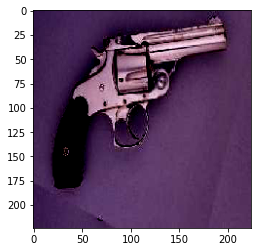

In [52]:
import matplotlib.pyplot as plt

aa = next(data_prep_fixed_size_gen)
#request_msg = request_prediction(aa)

bb = next(data_prep_for_onnx_gen)
#request_msg = request_prediction(bb)

cc = aa[0]
print(cc.shape)
plt.imshow(cc)

In [ ]:
predictor_url = 'http://172.17.0.2:8001/v1/models/default/versions/1:predict'

result = []
for i, _ in enumerate(data_prep_fixed_size_gen):

    img = _[0]
    request_msg = request_prediction(img)


    # Call predictor
    request_headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Host': '7d5af6497531',
    }
    response = requests.post(
        predictor_url,
        headers=request_headers,
        data=request_msg,
    )
    response_parsed = json_format.Parse(response.text, predict_pb2.PredictResponse())
    response_pred = np.frombuffer(response_parsed.outputs['probs'].raw_data, dtype=np.float32)
    response_data = decode_predictions(np.expand_dims(response_pred, axis=0))
    result += [response_data]
    
    if i > 20:
        break
    

result[-3:]

In [56]:
predictor_url = 'http://172.17.0.2:8001/v1/models/default/versions/1:predict'

result = []
for _ in data_prep_fixed_size_gen:
    
    img = _[0]
    request_msg = request_prediction(img)
    

    # Call predictor
    request_headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Host': '7d5af6497531',
    }
    response = requests.post(
        predictor_url,
        headers=request_headers,
        data=request_msg,
    )
    response_parsed = json_format.Parse(response.text, predict_pb2.PredictResponse())
    response_pred = np.frombuffer(response_parsed.outputs['probs'].raw_data, dtype=np.float32)
    response_data = decode_predictions(np.expand_dims(response_pred, axis=0))
    result += [response_data]

result[-3:]

[[[('n02437616', 'llama', 0.43487042),
   ('n01873310', 'platypus', 0.19912325),
   ('n02417914', 'ibex', 0.18232298),
   ('n02326432', 'hare', 0.027106429),
   ('n01877812', 'wallaby', 0.018452052)]],
 [[('n02389026', 'sorrel', 0.3951849),
   ('n02417914', 'ibex', 0.24218436),
   ('n02422106', 'hartebeest', 0.20695913),
   ('n02437312', 'Arabian_camel', 0.035300612),
   ('n02423022', 'gazelle', 0.02782558)]],
 [[('n02391049', 'zebra', 0.84348476),
   ('n02389026', 'sorrel', 0.089343),
   ('n02116738', 'African_hunting_dog', 0.005276417),
   ('n02091244', 'Ibizan_hound', 0.0048087407),
   ('n02509815', 'lesser_panda', 0.0024506175)]]]

```sh
CONTAINER ID        NAME                CPU %               MEM USAGE / LIMIT     MEM %               NET I/O             BLOCK I/O           PIDS
bdf1a647146f        admiring_wu         13.73%              28.91GiB / 62.85GiB   46.00%              6.95GB / 6.25GB     1.44GB / 16.5GB     231
b0b1b76efd26        suspicious_shtern   259.17%             210.5MiB / 62.85GiB   0.33%               5.34GB / 62.1MB     4.1kB / 0B          19
```

##### Build ONNXRuntime Server (`onnxruntime_server`)

```bash
git clone \
    -b rel-1.1.1 \
    --single-branch \
    https://github.com/microsoft/onnxruntime $WORKDIR/onnxruntime-git && \
cd $WORKDIR/onnxruntime-git && \
python ./tools/ci_build/build.py \
    --build_dir ./build \
    --config Release \
    --parallel \
    --cmake_extra_defines ONNXRUNTIME_VERSION=$(cat ./VERSION_NUMBER) && \
cd /"
```

---

# Further Readings

---
From: [ONNX_Runtime_Server_Usage](https://raw.githubusercontent.com/microsoft/onnxruntime/master/docs/ONNX_Runtime_Server_Usage.md)

---
## How to Use ONNX Runtime Server for Prediction
ONNX Runtime Server provides an easy way to start an inferencing server for prediction with both HTTP and GRPC endpoints.

### Build the Server

The CLI command to build the server is

Default CPU:

```bash
python3 /onnxruntime/tools/ci_build/build.py --build_dir /onnxruntime/build --config Release --build_server -parallel --cmake_extra_defines ONNXRUNTIME_VERSION=$(cat ./VERSION_NUMBER
```

### Start the Server

The CLI command to start the server is shown below:

```bash
$ ./onnxruntime_server
Version: <Build number>
Commit ID: <The latest commit ID>

the option '--model_path' is required but missing
Allowed options:
  -h [ --help ]                Shows a help message and exits
  --log_level arg (=info)      Logging level. Allowed options (case sensitive):
                               verbose, info, warning, error, fatal
  --model_path arg             Path to ONNX model
  --address arg (=0.0.0.0)     The base HTTP address
  --http_port arg (=8001)      HTTP port to listen to requests
  --num_http_threads arg (=<# of your cpu cores>) Number of http threads
  --grpc_port arg (=50051)     GRPC port to listen to requests
```

**Note**: The only mandatory argument for the program here is `model_path`


* To host an ONNX model as an inferencing server, simply run:

```bash
./onnxruntime_server --model_path /<your>/<model>/<path>
```

### Endpoint

#### HTTP Endpoint

The prediction URL for HTTP endpoint is in this format:

```url
http://<your_ip_address>:<port>/v1/models/<your-model-name>/versions/<your-version>:predict
```

#### GRPC Endpoint

If you prefer using the GRPC endpoint, the protobuf could be found [here](../onnxruntime/server/protobuf/prediction_service.proto). You could generate your client and make a GRPC call to it. To learn more about how to generate the client code and call to the server, please refer to [the tutorials of GRPC](https://grpc.io/docs/tutorials/).


**Note**: Since we currently only support one model, the model name and version can be any string length > 0. In the future, model_names and versions will be verified.

### Request and Response Payload

The request and response need to be a protobuf message. The Protobuf definition can be found [here](../onnxruntime/server/protobuf/predict.proto).

A protobuf message could have two formats: binary and JSON. Usually the binary payload has better latency, in the meanwhile the JSON format is easy for human readability. 

The HTTP request header field `Content-Type` tells the server how to handle the request and thus it is mandatory for all requests. Requests missing `Content-Type` will be rejected as `400 Bad Request`.

* For `"Content-Type: application/json"`, the payload will be deserialized as JSON string in UTF-8 format
* For `"Content-Type: application/vnd.google.protobuf"`, `"Content-Type: application/x-protobuf"` or `"Content-Type: application/octet-stream"`, the payload will be consumed as protobuf message directly.

Clients can control the response type by setting the request with an `Accept` header field and the server will serialize in your desired format. The choices currently available are the same as the `Content-Type` header field. If this field is not set in the request, the server will use the same type as your request.

### Inferencing

To send a request to the server, you can use any tool which supports making HTTP requests. Here is an example using `curl`:

```bash
curl -X POST -d "@predict_request_0.json" -H "Content-Type: application/json" http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

or

```bash
curl -X POST --data-binary "@predict_request_0.pb" -H "Content-Type: application/octet-stream" -H "Foo: 1234"  http://127.0.0.1:8001/v1/models/mymodel/versions/3:predict
```

### Interactive tutorial notebook

A simple Jupyter notebook demonstrating the usage of ONNX Runtime server to host an ONNX model and perform inferencing can be found [here](https://github.com/onnx/tutorials/blob/master/tutorials/OnnxRuntimeServerSSDModel.ipynb).


[Other Tutorials](https://github.com/onnx/tutorials/tree/master/tutorials)